### import the package

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**define the Class Camera**

Class Camera can be used to load the picture and cal_undistort

In [2]:
class Camera(object):
    """
    Camera is a class to define the camera
    """
    def __init__(self, nx, ny):
        """
        # initialize
        :param nx:
        :param ny:
        """
        self.nx = nx
        self.ny = ny
        self.objpoints = None
        self.imgpoints = None

    def _generate_array(self, length):
        """
        # generate imgpoints array
        # import by offical tutorial
        :param length:
        :return:
        """
        result = []
        objp = np.zeros((self.nx * self.ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1, 2)
        for i in range(length):
            result.append(objp)
        return result

    def load_picures(self, images):
        """
        # load picture to adjust the mtx and dist
        :param images:
        :return:
        """
        imgpoints = []
        for filename in images:
            # get an image
            img = mpimg.imread(filename)
            # transform to gray image
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # find the image color
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)
            if ret:
                # calculate the mtx and dist
                imgpoints.append(corners)
        self.objpoints = self._generate_array(len(imgpoints))
        self.imgpoints = imgpoints

    def cal_undistort(self, img):
        """
        # input distort image
        # and calculate undistort image by mtx and dist
        :param img:  the output of cv2.imread
        :return:
        """
        if self.objpoints is None or self.imgpoints is None:
            raise Exception("this camera is not to adjust, so cannot use to cal_undistort image")
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            self.objpoints, self.imgpoints, gray.shape[::-1], None, None
        )
        undist_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undist_img

Verify the Class Camera function

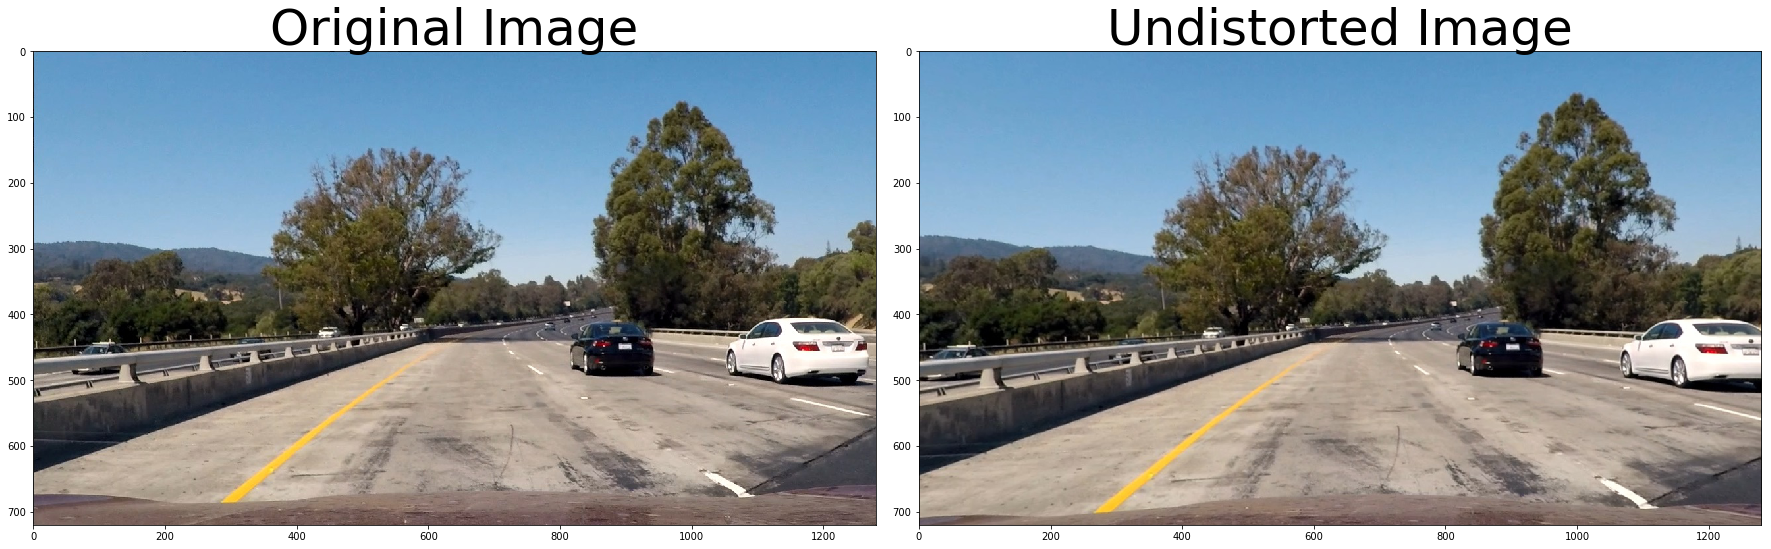

In [8]:
import os
camera = Camera(9, 6)
pictures_file_names = os.listdir("../camera_cal/")
pictures_list = ["../camera_cal/" + filename for filename in pictures_file_names]
# pictures_list = ["../camera_cal/calibration2.jpg"]
camera.load_picures(pictures_list)
test_picture = "../test_images/test1.jpg"
img = mpimg.imread(test_picture)
undistort_img = camera.cal_undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistort_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

**Calculate the perspective_transform**

In [6]:
def get_transform_m(src, dst):
    """
    # get the perspective transform function
    :param src:
    :param dst:
    :return:
    """
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


def perspective_transform(img, m):
    """
    # execute perspective transform
    :param img:
    :param m:
    :return:
    """
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, m, img_size, flags=cv2.INTER_LINEAR)
    return warped

test the perspective_transform

In [9]:
src = np.float32([[251.9, 688], [585.655, 455.895], [692.7, 455.895], [1054, 688]])
dst = np.float32([[300, 700], [300, 100], [900, 100], [900, 700]])

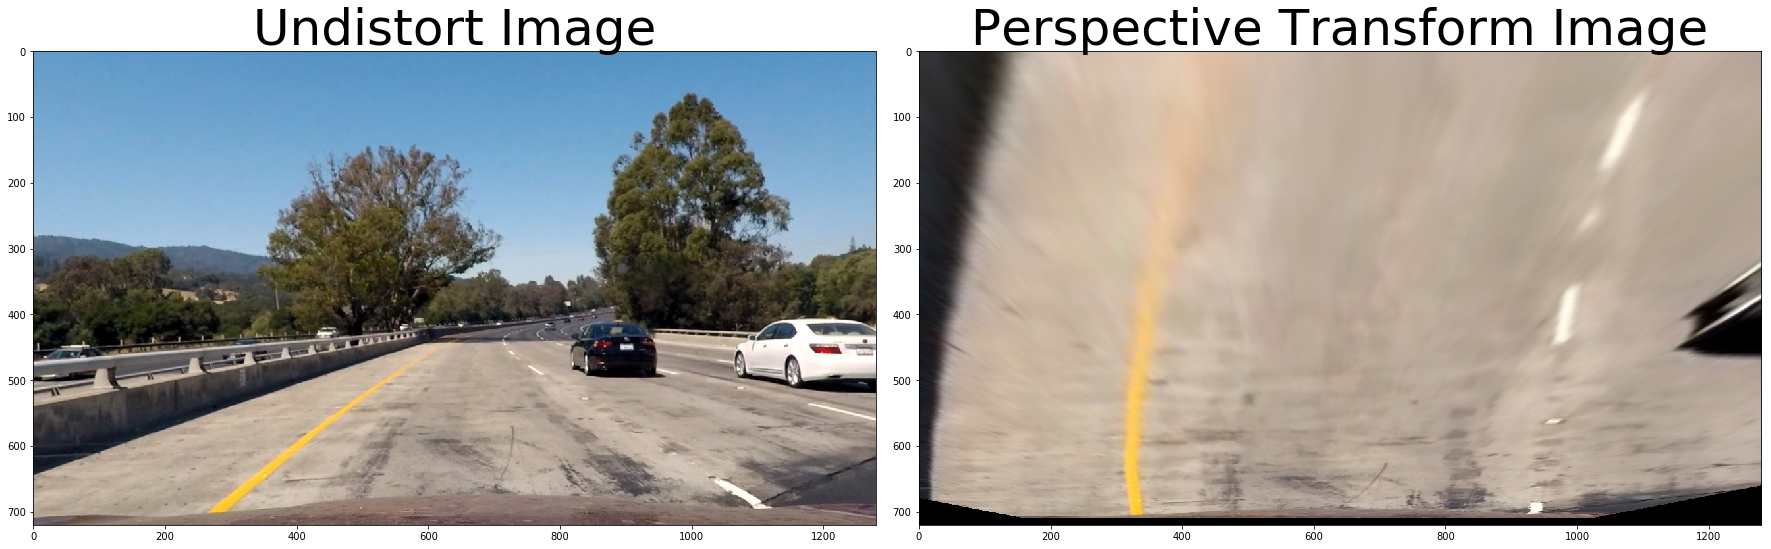

In [10]:
img_size = (img.shape[1], img.shape[0])
M, Minv = get_transform_m(src, dst)
perspective_transform_img = perspective_transform(undistort_img, M)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistort_img)
ax1.set_title('Undistort Image', fontsize=50)
ax2.imshow(perspective_transform_img)
ax2.set_title('Perspective Transform Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

double check the perspective_transform correct

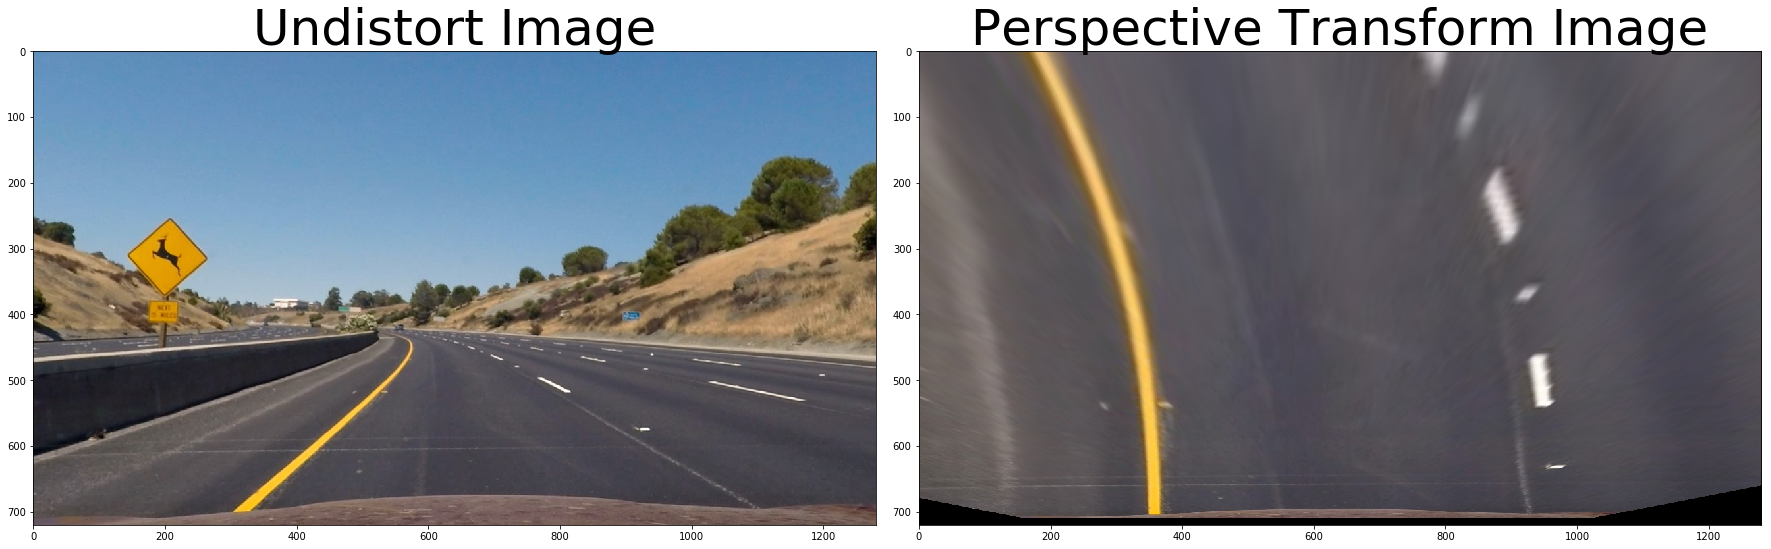

In [11]:
test_picture = "../test_images/test2.jpg"
img2 = mpimg.imread(test_picture)
undistort_img2 = camera.cal_undistort(img2)
img_size = (img2.shape[1], img2.shape[0])
M, Minv = get_transform_m(src, dst)
perspective_transform_img2 = perspective_transform(undistort_img2, M)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistort_img2)
ax1.set_title('Undistort Image', fontsize=50)
ax2.imshow(perspective_transform_img2)
ax2.set_title('Perspective Transform Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Define the thresholding filter

In [12]:
def color_thresholding_filter(img, min_thresholding, max_thresholding):
    """
    #
    :param img:
    :param min_thresholding:
    :param max_thresholding:
    :return:
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    result = np.zeros_like(s)
    result[(s >= min_thresholding) & (s <= max_thresholding)] = 1
    return result


def sobel_thresholding_filter(img, min_thresholding, max_thresholding, sobel_kernel):
    """
    #
    :param img:
    :param min_thresholding:
    :param max_thresholding:
    :return:
    """
    # convert color image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.power(np.power(sobelx, 2) + np.power(sobely, 2), 0.5)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # initial zeros array
    result = np.zeros_like(scaled_sobel)
    result[(scaled_sobel >= min_thresholding) & (scaled_sobel <= max_thresholding)] = 1
    return result


def gradient_thresholding_filter(img, min_thresholding, max_thresholding, sobel_kernel):
    """
    #
    :param img:
    :param min_thresholding:
    :param max_thresholding:
    :param sobel_kernel:
    :return:
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    gradient_sobel = np.arctan2(abs_sobely, abs_sobelx)
    result = np.zeros_like(gradient_sobel)
    result[(gradient_sobel >= min_thresholding) & (gradient_sobel <= max_thresholding)] = 1
    return result


def final_thresholding_filter(img, color_thresholding, gradient_thresholding, sobel_thresholding, sobel_kernal_size=3):
    """
    #
    :param img:
    :param color_thresholding:
    :param gradient_thresholding:
    :param sobel_thresholding:
    :param sobel_kernal_size:
    :return:
    """
    condition = (0 == 1)
    if color_thresholding:
        color_result = color_thresholding_filter(img, color_thresholding[0], color_thresholding[1])
        combined_result = np.zeros_like(color_result)
        condition = condition | (color_result == 1)
    if gradient_thresholding:
        gradient_result = gradient_thresholding_filter(img, gradient_thresholding[0], gradient_thresholding[1], sobel_kernal_size)
        combined_result = np.zeros_like(gradient_result)
        condition = condition | (gradient_result == 1)
    if sobel_thresholding:
        sobel_result = sobel_thresholding_filter(img, sobel_thresholding[0], sobel_thresholding[1], sobel_kernal_size)
        combined_result = np.zeros_like(sobel_result)
        condition = condition | (sobel_result == 1)

    try:
        combined_result[condition] = 1
    except Exception as e:
        raise Exception(str(e))
    return combined_result

**test the thresholding filter**

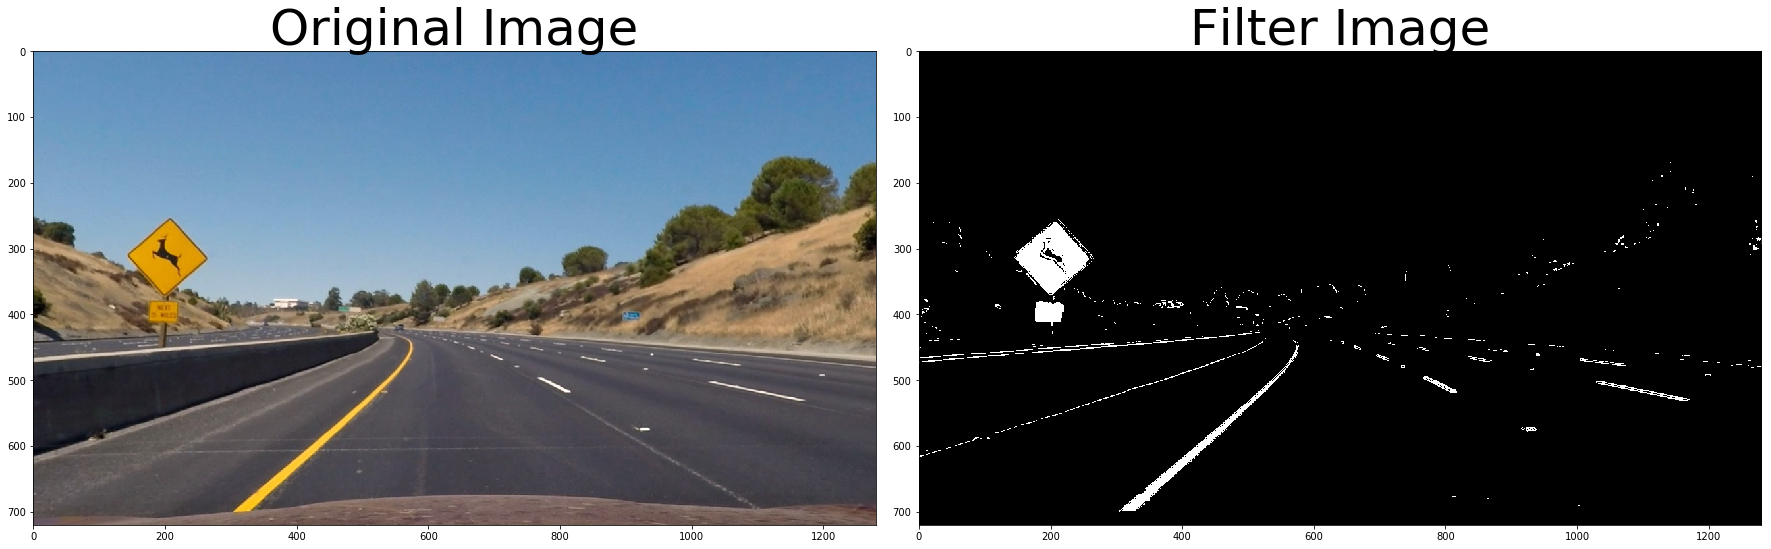

In [18]:
thresholding_filter_img = final_thresholding_filter(undistort_img2, [200, 255], [], [100, 255], sobel_kernal_size=3)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistort_img2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholding_filter_img, cmap='gray')
ax2.set_title('Filter Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

**Use the histogram the find the land line**

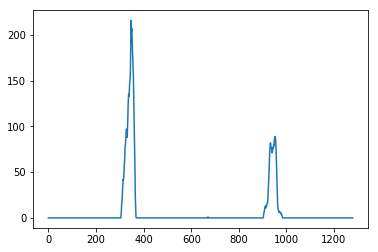

In [19]:
perspective_transform_for_filter_img = perspective_transform(thresholding_filter_img, M)
# plt.imshow(perspective_transform_for_filter_img)
histogram = np.sum(perspective_transform_for_filter_img[perspective_transform_for_filter_img.shape[0] // 2:, :], axis=0)
plt.plot(histogram)
plt.show()

**draw the land line**

In [21]:
binary_warped = perspective_transform_for_filter_img

(720, 0)

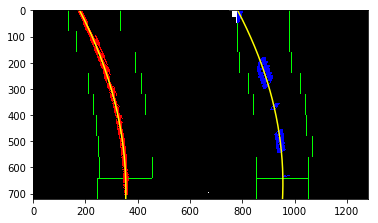

In [22]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2)
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

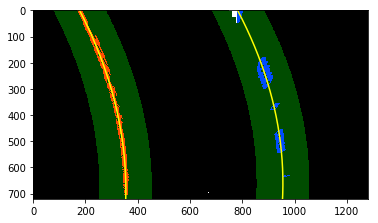

In [23]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

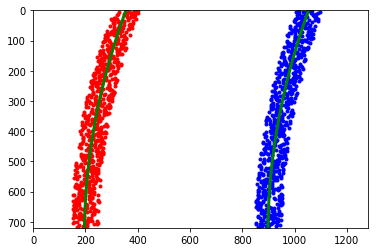

In [24]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [25]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1777.48479891 1790.4178168


In [26]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

583.536547166 m 587.876856743 m
